# NLP Project: Language Modeling Comparison
In this notebook is our code for the NLP Project 1_2. We begin 


## 0. Setup and Imports


In [1]:
import re
import html
import string
import math
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from typing import List, Optional, Union
from wordcloud import WordCloud
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Setup Visuals
sns.set_style("whitegrid")

# display plots directly
%matplotlib inline 

# Download resources if checks fail
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('wordnet', quiet=True)
    nltk.download('omw-1.4', quiet=True)
    
print("Libraries loaded.")



Libraries loaded.


## Task 1: Data Analysis

In [2]:
# Minimal cleaning and preprocessing
df = pd.read_csv("IMDB Dataset.csv")  # adjust path if needed

df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

def clean_text(text):
    text = text.lower()
    text = re.sub(r"<br\s*/?>", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['clean_review'] = df['review'].apply(clean_text)

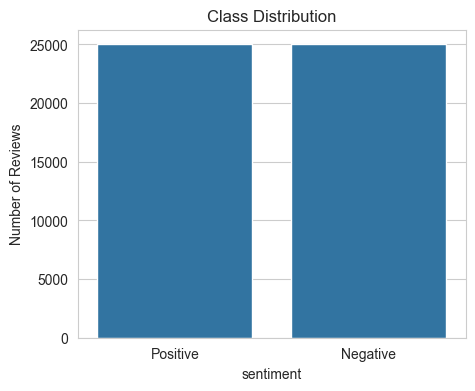

sentiment
1    25000
0    25000
Name: count, dtype: int64

In [3]:
# Class distribution
class_counts = df['sentiment'].value_counts()

plt.figure(figsize=(5,4))
sns.barplot(x=class_counts.index.map({1:"Positive",0:"Negative"}), y=class_counts.values)
plt.title("Class Distribution")
plt.ylabel("Number of Reviews")
plt.show()

class_counts

In [4]:
# word count per review
df['word_count'] = df['clean_review'].apply(lambda x: len(x.split()))

stats = df.groupby('sentiment')['word_count'].agg(['mean', 'median', 'std'])
stats.rename(index={1:'Positive',0:'Negative'})

,mean,median,std
sentiment,,,
Negative,227.11432,172.0,163.185663
Positive,230.62320,171.0,175.751225


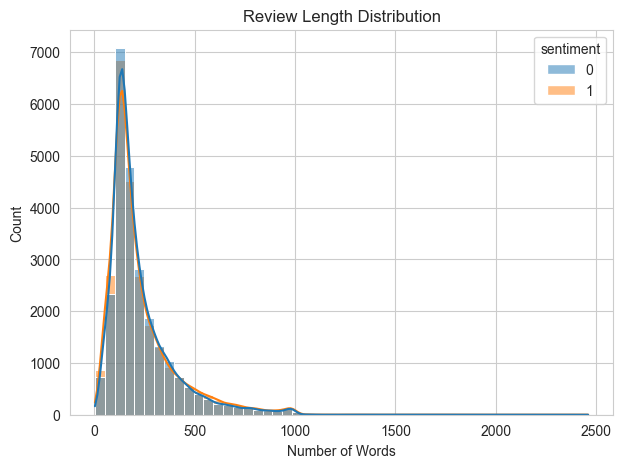

In [5]:
# Visualization of word count distribution per review and class
plt.figure(figsize=(7,5))
sns.histplot(data=df, x='word_count', hue='sentiment', bins=50, kde=True)
plt.title("Review Length Distribution")
plt.xlabel("Number of Words")
plt.show()

In [6]:
# Top content words per class (not needed)
stop_words = set(stopwords.words("english"))

def top_content_words(texts, n=20):
    c = Counter()
    for doc in texts:
        for w in doc.split():
            if w.isalpha() and w not in stop_words:
                c[w] += 1
    return pd.DataFrame(c.most_common(n), columns=["word", "count"])

top_pos_content = top_content_words(df[df.sentiment==1]["clean_review"], n=20)
top_neg_content = top_content_words(df[df.sentiment==0]["clean_review"], n=20)

display(top_pos_content)
display(top_neg_content)

,word,count
0,film,29392
1,movie,26710
2,one,23685
3,like,16441
4,good,11872
5,great,11234
6,see,11097
7,really,10351
8,would,10301
9,also,9788


,word,count
0,movie,34844
1,film,25744
2,one,22056
3,like,21032
4,even,14796
5,would,13537
6,good,11704
7,really,11493
8,bad,10676
9,see,9909


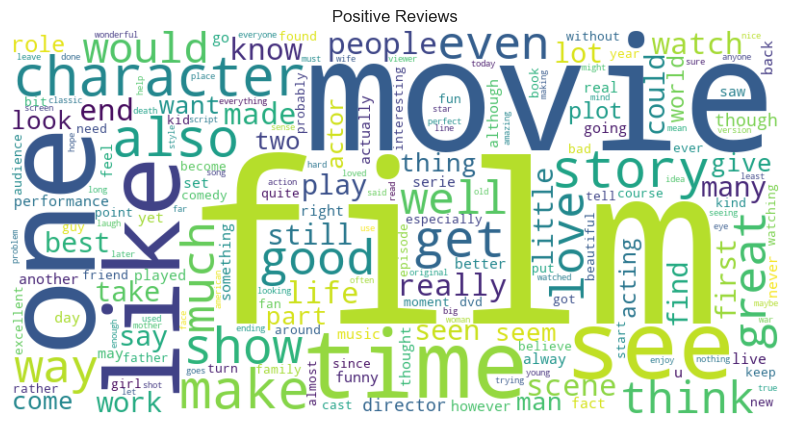

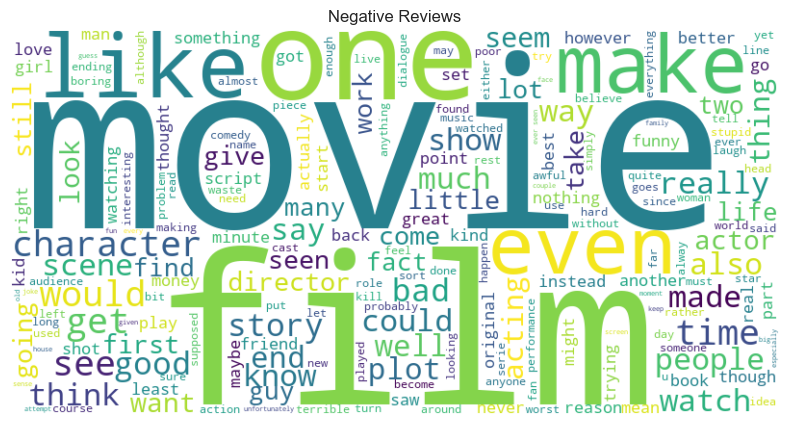

In [7]:
# Word Clouds per class
stop_words = set(stopwords.words('english'))

def plot_wordcloud(text, title):
    wc = WordCloud(
        width=800, height=400,
        stopwords=stop_words,
        background_color="white"
    ).generate(text)

    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

plot_wordcloud(" ".join(df[df.sentiment==1]['clean_review']), "Positive Reviews")
plot_wordcloud(" ".join(df[df.sentiment==0]['clean_review']), "Negative Reviews")

In [8]:
# Top bigrams overall 
bigram_vec = CountVectorizer(ngram_range=(2,2), min_df=20)
X2 = bigram_vec.fit_transform(df["clean_review"])
bigrams = bigram_vec.get_feature_names_out()
bigram_counts = np.asarray(X2.sum(axis=0)).ravel()

bigram_df = (pd.DataFrame({"ngram": bigrams, "count": bigram_counts})
               .sort_values("count", ascending=False))
display(bigram_df.head(20))


,ngram,count
33535,of the,77292
23037,in the,50281
49279,this movie,31541
45789,the film,26856
4007,and the,26715
46566,the movie,23896
51008,to the,23739
50148,to be,23492
49162,this film,21820
24966,it is,19918


In [9]:
# Vocabulary size and coverage analysis
all_words = " ".join(df['clean_review']).split()
word_counts = Counter(all_words)

total_tokens = sum(word_counts.values())
coverage = []

for k in [1000, 5000, 10000, 20000]:
    top_k = sum([count for _, count in word_counts.most_common(k)])
    coverage.append((k, top_k / total_tokens))

coverage_df = pd.DataFrame(coverage, columns=['Top-K Words', 'Token Coverage'])
coverage_df

,Top-K Words,Token Coverage
0,1000,0.703469
1,5000,0.834321
2,10000,0.880012
3,20000,0.917503


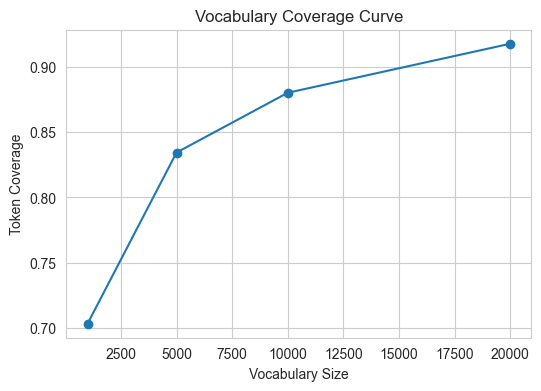

In [10]:
plt.figure(figsize=(6,4))
plt.plot(coverage_df['Top-K Words'], coverage_df['Token Coverage'], marker='o')
plt.title("Vocabulary Coverage Curve")
plt.ylabel("Token Coverage")
plt.xlabel("Vocabulary Size")
plt.show()

In [11]:
# Most Discriminative Words 
vectorizer = CountVectorizer(
    min_df=50,
    token_pattern=r'(?u)\b[a-z][a-z]+\b'
)
X = vectorizer.fit_transform(df["clean_review"])
vocab = vectorizer.get_feature_names_out()

pos_mask = (df["sentiment"] == 1).to_numpy()
neg_mask = (df["sentiment"] == 0).to_numpy()

pos_counts = X[pos_mask].sum(axis=0).A1
neg_counts = X[neg_mask].sum(axis=0).A1

log_odds = np.log((pos_counts + 1) / (neg_counts + 1))
log_odds_df = pd.DataFrame({"word": vocab, "log_odds": log_odds})

top_positive = log_odds_df.sort_values("log_odds", ascending=False).head(20)
top_negative = log_odds_df.sort_values("log_odds", ascending=True).head(20)

display(top_positive)
display(top_negative)

,word,log_odds
2816,edie,3.004031
3340,felix,2.873565
5507,matthau,2.856470
2851,eisenstein,2.790288
3102,excellently,2.740840
7078,raoul,2.533697
3282,farley,2.505526
2431,devito,2.468100
5711,miyazaki,2.380703
4000,haines,2.311635


,word,log_odds
9511,uwe,-4.356709
955,boll,-4.257974
5425,manos,-4.158883
8532,stinker,-2.963397
3561,forwarding,-2.961831
9304,turd,-2.736221
8495,steaming,-2.708050
8627,stunk,-2.691243
9724,waste,-2.680486
12,abomination,-2.614960


In [12]:
negations = {
    "not", "no", "never", 
    "don't", "dont", "didn't","didnt", "isn't", "isnt", "wasn't", "wasnt",
    "can't", "cant", "won't", "wont", "couldn't", "couldnt", "shouldn't", "shouldnt"
}

df['negation_count'] = df['clean_review'].apply(
    lambda x: sum(word in negations for word in x.split())
)

df.groupby('sentiment')['negation_count'].mean().rename(index={1:'Positive',0:'Negative'})

sentiment
Negative    3.21676
Positive    2.41776
Name: negation_count, dtype: float64

In [13]:
df['stopword_ratio'] = df['clean_review'].apply(
    lambda x: np.mean([word in stop_words for word in x.split()])
)

df.groupby('sentiment')['stopword_ratio'].mean().rename(index={1:'Positive',0:'Negative'})

sentiment
Negative    0.464169
Positive    0.461148
Name: stopword_ratio, dtype: float64

## Task 2: Text Preprocessor


In [14]:
class TextPreprocessor:
    def __init__(self, 
                 remove_html: bool = True,
                 lowercase: bool = True,
                 remove_punctuation: bool = False,
                 remove_stopwords: bool = False,
                 lemmatize: bool = False,
                 expand_contractions: bool = True):
        self.remove_html = remove_html
        self.lowercase = lowercase
        self.remove_punctuation = remove_punctuation
        self.remove_stopwords = remove_stopwords
        self.lemmatize = lemmatize
        self.expand_contractions = expand_contractions

        # Pre-load resources to optimize runtime
        self.stop_words = set(stopwords.words('english'))
        self.stop_words.remove("not")
        self.lemmatizer = WordNetLemmatizer()
        
        # Simple contraction map for expansion
        self.contractions_dict = {
            "isn't": "is not", "aren't": "are not", "wasn't": "was not", "weren't": "were not",
            "haven't": "have not", "hasn't": "has not", "hadn't": "had not", "won't": "will not",
            "wouldn't": "would not", "don't": "do not", "doesn't": "does not", "didn't": "did not",
            "can't": "cannot", "couldn't": "could not", "shouldn't": "should not", "mightn't": "might not",
            "mustn't": "must not", "i'm": "i am", "you're": "you are", "he's": "he is", "she's": "she is",
            "it's": "it is", "we're": "we are", "they're": "they are", "i've": "i have", "you've": "you have",
            "we've": "we have", "they've": "they have", "i'll": "i will", "you'll": "you will",
            "he'll": "he will", "she'll": "she will", "we'll": "we will", "they'll": "they will"
        }
        self.contractions_re = re.compile('(%s)' % '|'.join(self.contractions_dict.keys()))
        # Normalization Regexes
        self.whitespace_re = re.compile(r'\s+')
        self.apostrophe_re = re.compile(r"[’`´]")

    def _clean_html(self, text: str) -> str:
        """Removes HTML tags and unescapes HTML entities."""
        text = html.unescape(text)
        clean = re.compile('<.*?>')
        return re.sub(clean, ' ', text)

    def _expand_contractions(self, text: str) -> str:
        """Expands common English contractions."""
        def replace(match):
            return self.contractions_dict[match.group(0)]
        return self.contractions_re.sub(replace, text)

    def _remove_punct(self, text: str) -> str:
        """Removes punctuation by replacing it with spaces."""
        return re.sub(f'[{re.escape(string.punctuation)}]', ' ', text)

    def _normalize_whitespace(self, text: str) -> str:
        """Collapse whitespace and strip edges."""
        return self.whitespace_re.sub(" ", text).strip()

    def _normalize_apostrophes(self, text: str) -> str:
        """Normalize fancy apostrophes to standard one."""
        return self.apostrophe_re.sub("'", text)

    def process_text(self, text: str) -> Union[str, List[str]]:
        """
        Main execution method.
        """
        if not isinstance(text, str) or not text:
            return ""

        #  Cleaning
        if self.remove_html:
            text = self._clean_html(text)
        
        #  Normalization
        text = self._normalize_apostrophes(text)
        text = self._normalize_whitespace(text)

        #  Lowercasing
        if self.lowercase:
            text = text.lower()
            
        #  Expansion
        if self.expand_contractions:
            text = self._expand_contractions(text)

        #  Punctuation Removal
        if self.remove_punctuation:
            text = self._remove_punct(text)

        #  Tokenization
        tokens = word_tokenize(text)

        #  Stopword Removal
        if self.remove_stopwords:
            tokens = [w for w in tokens if w not in self.stop_words]

        #  Lemmatization
        if self.lemmatize:
            tokens = [self.lemmatizer.lemmatize(w) for w in tokens]

        return " ".join(tokens)


## Task 3: N-gram & LSTM

In [15]:
# Load Data
try:
    df = pd.read_csv('IMDB Dataset.csv')
    raw_reviews = df['review'].tolist()
    print(f"Loaded {len(raw_reviews)} reviews.")
except FileNotFoundError:
    print("IMDB Dataset.csv not found. Using dummy data.")
    raw_reviews = ["The movie was terrible.", "I loved the film. It was great.", "The acting was bad."] * 100

# Configuration
SAMPLE_SIZE = len(raw_reviews)  
raw_reviews = raw_reviews[:SAMPLE_SIZE]

Loaded 50000 reviews.


In [16]:
# 1. Pipeline for N-gram Models
print("Preprocessing for N-gram models...")
ngram_prep = TextPreprocessor(
    remove_html=True, 
    lowercase=True, 
    remove_punctuation=True, # Keep structure for n-grams
    remove_stopwords=False, 
    lemmatize=True, 
    expand_contractions=True
)


ngram_corpus = []
for r in raw_reviews:
    cleaned = ngram_prep.process_text(r)
    tokens = cleaned.split()
    tokens = ['<s>', '<s>'] + tokens + ['</s>']
    ngram_corpus.append(tokens)
print("Done.")

Preprocessing for N-gram models...
Done.


In [17]:
# 2. Pipeline for Neural Model
print("Preprocessing for Neural models...")
neural_prep = TextPreprocessor(
    remove_html=True, 
    lowercase=True, 
    remove_punctuation=False,
    remove_stopwords=False, 
    lemmatize=False,
    expand_contractions=True
)

neural_corpus = []
MAX_LEN = 100
for r in raw_reviews:
    cleaned = neural_prep.process_text(r)
    tokens = cleaned.split()
    tokens = ['<s>'] + tokens[:MAX_LEN] + ['</s>']
    neural_corpus.append(tokens)
print("Done.")

Preprocessing for Neural models...
Done.


In [18]:
# Split 
split_idx = int(len(raw_reviews) * 0.8)

train_ngram = ngram_corpus[:split_idx]
test_ngram  = ngram_corpus[split_idx:]

train_neural = neural_corpus[:split_idx]
test_neural  = neural_corpus[split_idx:]

print(f"Data ready. Train size: {len(train_ngram)}, Test size: {len(test_ngram)}")

Data ready. Train size: 40000, Test size: 10000


In [19]:
#3. Pipeline for Transformer (Sentiment Classification)
print("Preprocessing for Transformer models...")
transformer_prep = TextPreprocessor(
    remove_html=True, 
    lowercase=True, 
    remove_punctuation=False, 
    remove_stopwords=False, 
    lemmatize=False,
    expand_contractions=False
)

transformer_reviews = []
labels = []

if 'sentiment' in df.columns:
    sentiment_map = {'positive': 1, 'negative': 0}
    labels = df['sentiment'].map(sentiment_map).tolist()[:SAMPLE_SIZE]
else:
    print("Warning: 'sentiment' column not found. Creating dummy labels.")
    labels = [0] * len(raw_reviews) # Dummy

for r in raw_reviews:
    clean_text = transformer_prep.process_text(r)
    transformer_reviews.append(clean_text)

train_transformer = transformer_reviews[:split_idx]
test_transformer  = transformer_reviews[split_idx:]
train_labels = labels[:split_idx]
test_labels = labels[split_idx:]
print("Done.")

Preprocessing for Transformer models...
Done.


### Model Definitions


### Bigram Model


In [20]:
class BigramLanguageModel:
    def __init__(self, alpha=0.01):
        """
        Initialize the Bigram Model.
        
        Args:
            alpha (float): The smoothing parameter for Laplace smoothing. 
                           Default is 0.01.
        """
        self.alpha = alpha
        self.bigram_counts = defaultdict(lambda: defaultdict(int))
        self.unigram_counts = defaultdict(int)
        self.vocab = set()
        self.vocab_size = 0
        self.total_bigrams = 0
        self.total_unigrams = 0
        
        self.lambda1 = 0.3 # Unigram
        self.lambda2 = 0.7 # Bigram
        
    def train(self, corpus):
        """
        Trains the model on a corpus of tokenized sentences.
        Uses the full vocabulary (no <UNK> thresholding).
        """
        print("Training model on full vocabulary...")
        for sentence in corpus:
            # Update vocabulary and unigram counts
            for word in sentence:
                self.vocab.add(word)
                self.unigram_counts[word] += 1
                self.total_unigrams += 1
            
            # Update bigram counts
            for i in range(len(sentence) - 1):
                w_curr = sentence[i]
                w_next = sentence[i+1]
                self.bigram_counts[w_curr][w_next] += 1
                self.total_bigrams += 1
                
        self.vocab_size = len(self.vocab)
        print(f"Training complete. Vocab size: {self.vocab_size}")

    def get_probability(self, prev_word, word):
        """
        Calculates the interpolated probability P(word | prev_word).
        P = L2 * P(word|prev) + L1 * P(word)
        """
        # 1. Bigram Probability
        bigram_count = self.bigram_counts[prev_word][word]
        unigram_count_prev = self.unigram_counts[prev_word]
        
        p_bi_num = bigram_count + self.alpha
        p_bi_den = unigram_count_prev + (self.alpha * self.vocab_size)
        p_bi = p_bi_num / p_bi_den
        
        # 2. Unigram Probability
        unigram_count_word = self.unigram_counts[word]
        p_uni_num = unigram_count_word + self.alpha
        p_uni_den = self.total_unigrams + (self.alpha * self.vocab_size)
        p_uni = p_uni_num / p_uni_den
        
        return (self.lambda2 * p_bi) + (self.lambda1 * p_uni)

    def calculate_perplexity(self, test_corpus):
        """
        Calculates the perplexity of the model on a test corpus.
        """
        log_prob_sum = 0
        N = 0
        
        for sentence in test_corpus:
            for i in range(len(sentence) - 1):
                w_curr = sentence[i]
                w_next = sentence[i+1]
                
                # We do not replace with <UNK>. If a word is unknown,
                # get_probability handles it via smoothing.
                prob = self.get_probability(w_curr, w_next)
                
                log_prob_sum += math.log2(prob)
                N += 1
        
        if N == 0: return float('inf')
        
        avg_log_prob = -log_prob_sum / N
        perplexity = 2 ** avg_log_prob
        return perplexity

    def generate_sentence(self, max_length=20):
        """
        Generates a random sentence.
        """
        current_word = "<s>"
        sentence = [current_word]
        
        for _ in range(max_length):
            if current_word == "</s>":
                break
            
            possible_next = self.bigram_counts[current_word]
            
            if not possible_next:
                break 

            candidates = list(possible_next.keys())
            counts = list(possible_next.values())
            
            next_word = random.choices(candidates, weights=counts, k=1)[0]
            
            sentence.append(next_word)
            current_word = next_word
            
        return " ".join(sentence[1:])

    def autocomplete(self, prompt, preprocessor, max_length=20):
        """
        Completes a given text prompt.
        """
        cleaned_prompt = preprocessor.process_text(prompt)
        tokens = cleaned_prompt.split()
        
        if not tokens:
            current_word = "<s>"
        else:
            current_word = tokens[-1]
        
        generated_tokens = []
        for _ in range(max_length):
            if current_word == "</s>":
                break
            
            possible_next = self.bigram_counts[current_word]
            
            if not possible_next:
                break
                
            candidates = list(possible_next.keys())
            counts = list(possible_next.values())
            
            next_word = random.choices(candidates, weights=counts, k=1)[0]
            
            generated_tokens.append(next_word)
            current_word = next_word
            
        return prompt + " " + " ".join(generated_tokens)

    def autocomplete(self, prompt, preprocessor, max_length=20):
        """
        Completes a given text prompt using the trained model.
        """
        # Preprocess the prompt to get the last token
        cleaned_prompt = preprocessor.process_text(prompt)
        tokens = cleaned_prompt.split()
        
        if not tokens:
            current_word = "<s>"
        else:
            current_word = tokens[-1]
            
        # Handle OOV for the seed word
        if current_word not in self.vocab:
            # Optionally print a warning or fallback
            current_word = "<UNK>"
            
        # Generate continuation
        generated_tokens = []
        for _ in range(max_length):
            if current_word == "</s>":
                break
            
            possible_next = self.bigram_counts[current_word]
            
            if not possible_next:
                current_word = "<UNK>"
                possible_next = self.bigram_counts[current_word]

            if not possible_next:
                break
                
            candidates = list(possible_next.keys())
            counts = list(possible_next.values())
            
            next_word = random.choices(candidates, weights=counts, k=1)[0]
            
            generated_tokens.append(next_word)
            current_word = next_word
            
        return prompt + " " + " ".join(generated_tokens)
class SimpleBigramLanguageModel:
    def __init__(self, alpha=0.01):
        self.alpha = alpha
        self.bigram_counts = defaultdict(lambda: defaultdict(int))
        self.unigram_counts = defaultdict(int)
        self.vocab = set()
        self.vocab_size = 0
        
    def train(self, corpus):
        print("Training Simple Bigram on full vocabulary...")
        for sentence in corpus:
            for word in sentence:
                self.vocab.add(word)
                self.unigram_counts[word] += 1
            
            for i in range(len(sentence) - 1):
                w_curr = sentence[i]
                w_next = sentence[i+1]
                self.bigram_counts[w_curr][w_next] += 1
                
        self.vocab_size = len(self.vocab)
        print(f"Simple Bigram Training complete. Vocab size: {self.vocab_size}")

    def get_probability(self, prev_word, word):
        bigram_count = self.bigram_counts[prev_word][word]
        unigram_count_prev = self.unigram_counts[prev_word]
        
        num = bigram_count + self.alpha
        den = unigram_count_prev + (self.alpha * self.vocab_size)
        return num / den

    def calculate_perplexity(self, test_corpus):
        log_prob_sum = 0
        N = 0
        
        for sentence in test_corpus:
            for i in range(len(sentence) - 1):
                w_curr = sentence[i]
                w_next = sentence[i+1]
                prob = self.get_probability(w_curr, w_next)
                log_prob_sum += math.log2(prob)
                N += 1
        
        if N == 0: return float('inf')
        
        avg_log_prob = -log_prob_sum / N
        perplexity = 2 ** avg_log_prob
        return perplexity

    def generate_sentence(self, max_length=20):
        current_word = "<s>"
        sentence = [current_word]
        
        for _ in range(max_length):
            if current_word == "</s>":
                break
            possible_next = self.bigram_counts[current_word]
            if not possible_next:
                break 

            candidates = list(possible_next.keys())
            counts = list(possible_next.values())
            next_word = random.choices(candidates, weights=counts, k=1)[0]
            sentence.append(next_word)
            current_word = next_word
        return " ".join(sentence[1:])

    def autocomplete(self, prompt, preprocessor, max_length=20):
        cleaned_prompt = preprocessor.process_text(prompt)
        tokens = cleaned_prompt.split()
        if not tokens:
            current_word = "<s>"
        else:
            current_word = tokens[-1]
        if current_word not in self.vocab:
            current_word = "<UNK>"
            
        generated_tokens = []
        for _ in range(max_length):
            if current_word == "</s>":
                break
            possible_next = self.bigram_counts[current_word]
            if not possible_next:
                current_word = "<UNK>"
                possible_next = self.bigram_counts[current_word]
            if not possible_next:
                break
            candidates = list(possible_next.keys())
            counts = list(possible_next.values())
            next_word = random.choices(candidates, weights=counts, k=1)[0]
            generated_tokens.append(next_word)
            current_word = next_word
        return prompt + " " + " ".join(generated_tokens)


### Trigram Model


In [21]:
class TrigramLanguageModel:
    def __init__(self, alpha=0.01):
        """
        Initialize the Trigram Model.
        
        Args:
            alpha (float): The smoothing parameter for Laplace smoothing. 
                           Default is 0.01.
        """
        self.alpha = alpha
        # trigram_counts: count of (w1, w2, w3) aka given w1, w2, what is w3?
        # Structure: dict[(w1, w2)] -> dict[w3] -> count
        self.trigram_counts = defaultdict(lambda: defaultdict(int))
        
        # bigram_counts: count of (w1, w2) as a history.
        # Structure: dict[(w1, w2)] -> count
        self.bigram_counts = defaultdict(int)
        self.unigram_counts = defaultdict(int)
        
        self.vocab = set()
        self.vocab_size = 0
        self.total_trigrams = 0
        self.total_unigrams = 0
        
        # Interpolation weights
        self.lambda1 = 0.1 # Unigram
        self.lambda2 = 0.3 # Bigram
        self.lambda3 = 0.6 # Trigram
        
    def train(self, corpus):
        """
        Trains the model on a corpus of tokenized sentences.
        """
        print("Training model on full vocabulary...")
        for sentence in corpus:
            # Update vocabulary and unigram counts
            for word in sentence:
                self.vocab.add(word)
                self.unigram_counts[word] += 1
                self.total_unigrams += 1
            
            # Update bigram counts (for backoff)
            for i in range(len(sentence) - 1):
                self.bigram_counts[(sentence[i], sentence[i+1])] += 1

            # Update trigram counts
            # Sentence is expected to be padded like ['<s>', '<s>', 'w1', ..., 'wn', '</s>']
            for i in range(len(sentence) - 2):
                w_1 = sentence[i]
                w_2 = sentence[i+1]
                w_3 = sentence[i+2]
                
                self.trigram_counts[(w_1, w_2)][w_3] += 1
                self.total_trigrams += 1
                
        self.vocab_size = len(self.vocab)
        print(f"Training complete. Vocab size: {self.vocab_size}")

    def get_probability(self, w_1, w_2, w_3):
        """
        Calculates the interpolated probability P(w_3 | w_1, w_2).
        P = L3 * P(w3|w1,w2) + L2 * P(w3|w2) + L1 * P(w3)
        """
        # 1. Trigram Probability
        trigram_count = self.trigram_counts[(w_1, w_2)][w_3]
        bigram_context_count = self.bigram_counts[(w_1, w_2)]
        
        p_tri_num = trigram_count + self.alpha
        p_tri_den = bigram_context_count + (self.alpha * self.vocab_size)
        p_tri = p_tri_num / p_tri_den
        
        # 2. Bigram Probability (Backoff)
        bigram_count = self.bigram_counts[(w_2, w_3)]
        unigram_context_count = self.unigram_counts[w_2]
        
        p_bi_num = bigram_count + self.alpha
        p_bi_den = unigram_context_count + (self.alpha * self.vocab_size)
        p_bi = p_bi_num / p_bi_den
        
        # 3. Unigram Probability
        unigram_count = self.unigram_counts[w_3]
        p_uni_num = unigram_count + self.alpha
        p_uni_den = self.total_unigrams + (self.alpha * self.vocab_size)
        p_uni = p_uni_num / p_uni_den
        
        return (self.lambda3 * p_tri) + (self.lambda2 * p_bi) + (self.lambda1 * p_uni)

    def calculate_perplexity(self, test_corpus):
        """
        Calculates the perplexity of the model on a test corpus.
        """
        log_prob_sum = 0
        N = 0
        
        for sentence in test_corpus:
            for i in range(len(sentence) - 2):
                w_1 = sentence[i]
                w_2 = sentence[i+1]
                w_3 = sentence[i+2]
                
                prob = self.get_probability(w_1, w_2, w_3)
                
                log_prob_sum += math.log2(prob)
                N += 1
        
        if N == 0: return float('inf')
        
        avg_log_prob = -log_prob_sum / N
        perplexity = 2 ** avg_log_prob
        return perplexity

    def generate_sentence(self, max_length=20):
        """
        Generates a random sentence.
        """
        # Start with two padding tokens
        current_w1 = "<s>"
        current_w2 = "<s>"
        sentence = [current_w1, current_w2]
        
        for _ in range(max_length):
            # If we generated the end token, stop
            if current_w2 == "</s>":
                break
                
            possible_next = self.trigram_counts[(current_w1, current_w2)]
            
            if not possible_next:
                # If unknown history, we can't progress. 
                break 

            candidates = list(possible_next.keys())
            counts = list(possible_next.values())
            
            next_word = random.choices(candidates, weights=counts, k=1)[0]
            
            sentence.append(next_word)
            current_w1 = current_w2
            current_w2 = next_word
        return " ".join(sentence[2:])

    def autocomplete(self, prompt, preprocessor, max_length=20):
        """
        Completes a given text prompt using the trained model.
        """
        cleaned_prompt = preprocessor.process_text(prompt)
        tokens = cleaned_prompt.split()
        
        # Determine context words (need 2)
        if len(tokens) >= 2:
            current_w1 = tokens[-2]
            current_w2 = tokens[-1]
        elif len(tokens) == 1:
            current_w1 = "<s>"
            current_w2 = tokens[-1]
        else:
            current_w1 = "<s>"
            current_w2 = "<s>"

        generated_tokens = []
        for _ in range(max_length):
            if current_w2 == "</s>":
                break
            
            possible_next = self.trigram_counts[(current_w1, current_w2)]
            
            if not possible_next:
                break
                
            candidates = list(possible_next.keys())
            counts = list(possible_next.values())
            
            next_word = random.choices(candidates, weights=counts, k=1)[0]
            
            generated_tokens.append(next_word)
            current_w1 = current_w2
            current_w2 = next_word
            
        return prompt + " " + " ".join(generated_tokens)
class SimpleTrigramLanguageModel:
    def __init__(self, alpha=0.01):
        self.alpha = alpha
        self.trigram_counts = defaultdict(lambda: defaultdict(int))
        self.bigram_counts = defaultdict(int)
        self.vocab = set()
        self.vocab_size = 0
        
    def train(self, corpus):
        print("Training Simple Trigram on full vocabulary...")
        for sentence in corpus:
            for word in sentence:
                self.vocab.add(word)
            
            for i in range(len(sentence) - 1):
                self.bigram_counts[(sentence[i], sentence[i+1])] += 1

            for i in range(len(sentence) - 2):
                w_1 = sentence[i]
                w_2 = sentence[i+1]
                w_3 = sentence[i+2]
                self.trigram_counts[(w_1, w_2)][w_3] += 1
                
        self.vocab_size = len(self.vocab)
        print(f"Simple Trigram Training complete. Vocab size: {self.vocab_size}")

    def get_probability(self, w_1, w_2, w_3):
        trigram_count = self.trigram_counts[(w_1, w_2)][w_3]
        bigram_context_count = self.bigram_counts[(w_1, w_2)]
        
        num = trigram_count + self.alpha
        den = bigram_context_count + (self.alpha * self.vocab_size)
        return num / den

    def calculate_perplexity(self, test_corpus):
        log_prob_sum = 0
        N = 0
        
        for sentence in test_corpus:
            for i in range(len(sentence) - 2):
                w_1 = sentence[i]
                w_2 = sentence[i+1]
                w_3 = sentence[i+2]
                prob = self.get_probability(w_1, w_2, w_3)
                log_prob_sum += math.log2(prob)
                N += 1
        
        if N == 0: return float('inf')
        
        avg_log_prob = -log_prob_sum / N
        perplexity = 2 ** avg_log_prob
        return perplexity

    def generate_sentence(self, max_length=20):
        current_w1 = "<s>"
        current_w2 = "<s>"
        sentence = [current_w1, current_w2]
        
        for _ in range(max_length):
            if current_w2 == "</s>":
                break
            possible_next = self.trigram_counts[(current_w1, current_w2)]
            if not possible_next:
                break 

            candidates = list(possible_next.keys())
            counts = list(possible_next.values())
            next_word = random.choices(candidates, weights=counts, k=1)[0]
            sentence.append(next_word)
            current_w1 = current_w2
            current_w2 = next_word
            
        return " ".join(sentence[2:])

    def autocomplete(self, prompt, preprocessor, max_length=20):
        cleaned_prompt = preprocessor.process_text(prompt)
        tokens = cleaned_prompt.split()
        if len(tokens) >= 2:
            current_w1 = tokens[-2]
            current_w2 = tokens[-1]
        elif len(tokens) == 1:
            current_w1 = "<s>"
            current_w2 = tokens[-1]
        else:
            current_w1 = "<s>"
            current_w2 = "<s>"
        generated_tokens = []
        for _ in range(max_length):
            if current_w2 == "</s>":
                break
            possible_next = self.trigram_counts[(current_w1, current_w2)]
            if not possible_next:
                break
            candidates = list(possible_next.keys())
            counts = list(possible_next.values())
            next_word = random.choices(candidates, weights=counts, k=1)[0]
            generated_tokens.append(next_word)
            current_w1 = current_w2
            current_w2 = next_word
        return prompt + " " + " ".join(generated_tokens)


### Neural Model (LSTM)


In [22]:
class Vocabulary:
    def __init__(self, token_to_idx=None):
        if token_to_idx:
            self.token_to_idx = token_to_idx
        else:
            self.token_to_idx = {"<PAD>": 0, "<UNK>": 1, "<s>": 2, "</s>": 3}
        self.idx_to_token = {v: k for k, v in self.token_to_idx.items()}
        
    def build_vocab(self, sentences, min_freq=2):
        print("Building vocabulary...")
        all_tokens = [token for sent in sentences for token in sent]
        counts = Counter(all_tokens)
        
        for token, count in counts.items():
            if count >= min_freq and token not in self.token_to_idx:
                self.token_to_idx[token] = len(self.token_to_idx)
                
        self.idx_to_token = {v: k for k, v in self.token_to_idx.items()}
        print(f"Vocabulary size: {len(self.token_to_idx)}")
        
    def __len__(self):
        return len(self.token_to_idx)
    
    def stoi(self, token):
        return self.token_to_idx.get(token, self.token_to_idx["<UNK>"])
        
    def itos(self, idx):
        return self.idx_to_token.get(idx, "<UNK>")

In [23]:
class IMDBDataset(Dataset):
    def __init__(self, sentences, vocab):
        self.sentences = sentences
        self.vocab = vocab
        
    def __len__(self):
        return len(self.sentences)
        
    def __getitem__(self, idx):
        tokenized_sent = self.sentences[idx]
        # Numericalize
        indexed = [self.vocab.stoi(t) for t in tokenized_sent]
        return torch.tensor(indexed, dtype=torch.long)

def collate_fn(batch):
    """
    Custom collate function to handle variable length sentences via padding.
    """
    batch.sort(key=lambda x: len(x), reverse=True)
    inputs = [item[:-1] for item in batch]
    targets = [item[1:] for item in batch]
    
    lengths = torch.tensor([len(x) for x in inputs], dtype=torch.long)
    
    # Pad sequences
    inputs_padded = pad_sequence(inputs, batch_first=True, padding_value=0)
    targets_padded = pad_sequence(targets, batch_first=True, padding_value=0)
    
    return inputs_padded, targets_padded, lengths

In [24]:
class NeuralLM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(NeuralLM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, x, lengths=None, hidden=None):
        # x: (batch, seq_len)
        embed = self.embedding(x) # (batch, seq_len, embed_dim)
        
        if lengths is not None:
            # Pack
            packed_embed = pack_padded_sequence(embed, lengths.cpu(), batch_first=True, enforce_sorted=True)
            packed_out, hidden = self.lstm(packed_embed, hidden)
            # Unpack
            output, _ = pad_packed_sequence(packed_out, batch_first=True)
        else:
            # No packing 
            output, hidden = self.lstm(embed, hidden)
        logits = self.fc(output) 
        return logits, hidden

In [25]:
def generate_text(model, vocab, start_prompt="The movie", max_len=20, device='cpu', temperature=1.0):
    model.eval()
    preprocessor = TextPreprocessor(lowercase=True)
    tokens = preprocessor.process_text(start_prompt).split()
    
    current_idx = [vocab.stoi(t) for t in tokens]
    
    input_seq = torch.tensor(current_idx, dtype=torch.long).unsqueeze(0).to(device) 
    
    generated = list(tokens)
    
    hidden = None
    
    with torch.no_grad():
        for _ in range(max_len):
            logits, hidden = model(input_seq, hidden=hidden)
            
            # Get last time step
            last_logits = logits[0, -1, :]
            
            # Apply temperature
            if temperature != 1.0:
                last_logits = last_logits / temperature
                
            probs = torch.softmax(last_logits, dim=0)
            
            # Sample
            next_token_idx = torch.multinomial(probs, 1).item()
            next_token = vocab.itos(next_token_idx)
            
            if next_token == "</s>":
                break
                
            generated.append(next_token)
            input_seq = torch.tensor([[next_token_idx]], dtype=torch.long).to(device)
            
    return " ".join(generated)

### Comparison: Bigram vs Trigram
We compare the perplexity and generation quality of the statistical models.


In [26]:
# Initialize
bigram_model = BigramLanguageModel(alpha=0.01)
simple_bigram_model = SimpleBigramLanguageModel(alpha=0.01)
trigram_model = TrigramLanguageModel(alpha=0.01)
simple_trigram_model = SimpleTrigramLanguageModel(alpha=0.01)

In [27]:
# Train Bigram
print("Training Bigram...")
start = time.time()
train_bi_adapted = [s[1:] for s in train_ngram] 
test_bi_adapted = [s[1:] for s in test_ngram]
bigram_model.train(train_bi_adapted)
bigram_time = time.time() - start
print(f"Bigram Trained in {bigram_time:.4f}s")

Training Bigram...
Training model on full vocabulary...
Training complete. Vocab size: 84480
Bigram Trained in 10.3668s


In [28]:
# Train Simple Bigram
print("Training Simple Bigram...")
start = time.time()
simple_bigram_model.train(train_bi_adapted)
simple_bigram_time = time.time() - start
print(f"Simple Bigram Trained in {simple_bigram_time:.4f}s")

Training Simple Bigram...
Training Simple Bigram on full vocabulary...
Simple Bigram Training complete. Vocab size: 84480
Simple Bigram Trained in 9.5523s


In [29]:
# Train Trigram
print("Training Trigram...")
start = time.time()
trigram_model.train(train_ngram)
trigram_time = time.time() - start
print(f"Trigram Trained in {trigram_time:.4f}s")

Training Trigram...
Training model on full vocabulary...
Training complete. Vocab size: 84480
Trigram Trained in 27.7409s


In [30]:
# Train Simple Trigram
print("Training Simple Trigram...")
start = time.time()
simple_trigram_model.train(train_ngram)
simple_trigram_time = time.time() - start
print(f"Simple Trigram Trained in {simple_trigram_time:.4f}s")

Training Simple Trigram...
Training Simple Trigram on full vocabulary...
Simple Trigram Training complete. Vocab size: 84480
Simple Trigram Trained in 24.7106s


In [31]:
# Perplexity
pp_bi = bigram_model.calculate_perplexity(test_bi_adapted)
pp_simple_bi = simple_bigram_model.calculate_perplexity(test_bi_adapted)
pp_tri = trigram_model.calculate_perplexity(test_ngram)
pp_simple_tri = simple_trigram_model.calculate_perplexity(test_ngram)

print(f"\nBigram Perplexity: {pp_bi:.2f}")
print(f"Simple Bigram Perplexity: {pp_simple_bi:.2f}")
print(f"Trigram Perplexity: {pp_tri:.2f}")
print(f"Simple Trigram Perplexity: {pp_simple_tri:.2f}")


Bigram Perplexity: 363.52
Simple Bigram Perplexity: 450.25
Trigram Perplexity: 464.91
Simple Trigram Perplexity: 2978.32


In [32]:
# Generation Comparison
print("\n--- Generation Comparison (Unprompted) ---")
print("Bigram:")
for i in range(2):
    print(f"  {i+1}. {bigram_model.generate_sentence()}")
print("Simple Bigram:")
for i in range(2):
    print(f"  {i+1}. {simple_bigram_model.generate_sentence()}")

print("\nTrigram:")
for i in range(2):
    print(f"  {i+1}. {trigram_model.generate_sentence()}")
print("Simple Trigram:")
for i in range(2):
    print(f"  {i+1}. {simple_trigram_model.generate_sentence()}")


--- Generation Comparison (Unprompted) ---
Bigram:
  1. this is the era still am genuinely care bear it say about chapter play the problem she start with his
  2. have a very hard to serious part of reginald denny is one wonder what would like it originally devised by
Simple Bigram:
  1. why the same applies here called plague or any film and so wooden the ground it for all the beginning
  2. in an interesting fall short you will jessica sigrid thornton seachange two by the film and can not explainable david

Trigram:
  1. garlin is trying to stay and i found this movie wa not one of the top billing i thought long
  2. so american movie classic no john woo the film she looked way too sweet her character that she became prom
Simple Trigram:
  1. c mon if there only a little titillation with plenty of that one no one in genuine fright it kind
  2. after the police inspector i am gon na be movie that show i can make up for that and finally


### Comprehensive Comparison (LSTM vs N-grams)
Comparing Logic, Training Time, and Perplexity.


In [33]:
# Train Neural Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training Neural Model on {device}...")

# Config
EMBED_DIM = 64
HIDDEN_DIM = 512
BATCH_SIZE = 64
LEARNING_RATE = 0.005
NUM_EPOCHS = 6 

# Setup
vocab = Vocabulary()
vocab.build_vocab(train_neural, min_freq=2) # => lowers perplexity and decreases train time
dataset = IMDBDataset(train_neural, vocab)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

model_lstm = NeuralLM(len(vocab), EMBED_DIM, HIDDEN_DIM).to(device)
optimizer = optim.Adam(model_lstm.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=0)

Training Neural Model on cuda...
Building vocabulary...
Vocabulary size: 40254


In [34]:
# Training Loop
start = time.time()
model_lstm.train()
loss_history = []

print(f"Starting Training. ")
for epoch in range(NUM_EPOCHS):
    epoch_loss = 0
    for inputs, targets, lengths in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        logits, _ = model_lstm(inputs, lengths)
        loss = criterion(logits.view(-1, len(vocab)), targets.view(-1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    navg = epoch_loss / len(dataloader)
    loss_history.append(navg)
    print(f"Epoch {epoch+1}: Loss {navg:.4f}")

neural_time = time.time() - start
print(f"Neural Trained in {neural_time:.4f}s")

Starting Training. 
Epoch 1: Loss 5.4848
Epoch 2: Loss 4.7458
Epoch 3: Loss 4.4366
Epoch 4: Loss 4.2117
Epoch 5: Loss 4.0330
Epoch 6: Loss 3.8879
Neural Trained in 370.3971s


In [35]:
# Neural Perplexity (Approximate on Test Set)
test_ds = IMDBDataset(test_neural, vocab)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn)
model_lstm.eval()
total_n_loss = 0
total_batches = 0
with torch.no_grad():
    for inputs, targets, lengths in test_dl:
        inputs, targets = inputs.to(device), targets.to(device)
        logits, _ = model_lstm(inputs, lengths)
        # Loss per batch
        loss = criterion(logits.view(-1, len(vocab)), targets.view(-1))
        total_n_loss += loss.item()
        total_batches += 1

avg_test_loss = total_n_loss / total_batches if total_batches > 0 else 999
pp_neural = math.exp(avg_test_loss)
print(f"Neural Perplexity: {pp_neural:.2f}")

Neural Perplexity: 136.02


### Performance Visualization


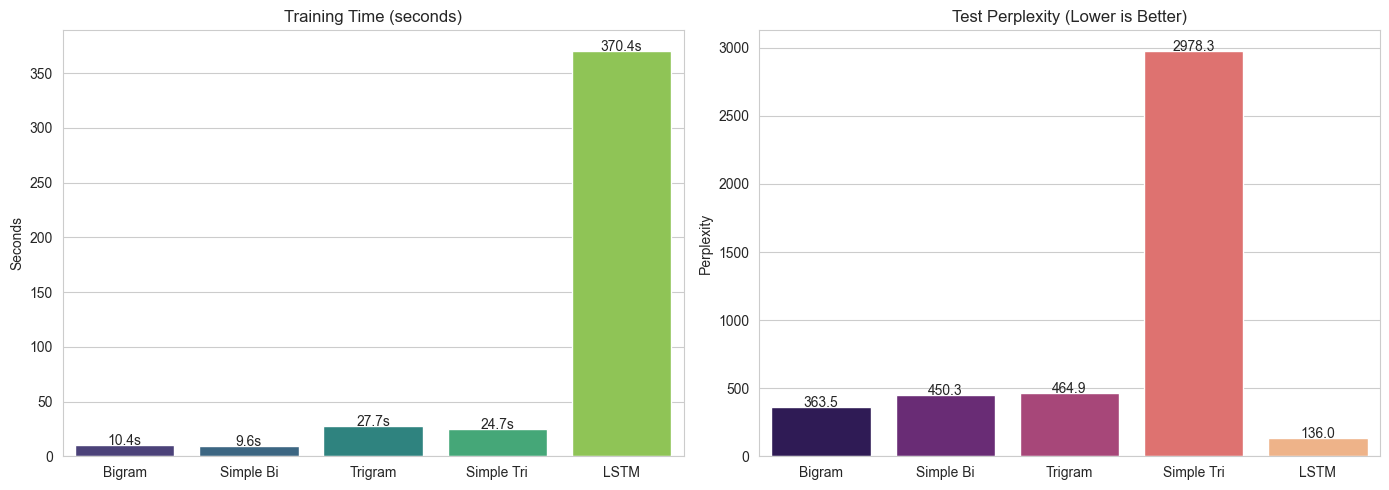

In [36]:

models = ['Bigram', 'Simple Bi', 'Trigram', 'Simple Tri', 'LSTM']
times = [bigram_time, simple_bigram_time, trigram_time, simple_trigram_time, neural_time]
perplexities = [pp_bi, pp_simple_bi, pp_tri, pp_simple_tri, pp_neural]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Time Plot
sns.barplot(x=models, y=times, hue=models, ax=axes[0], palette="viridis", legend=False)
axes[0].set_title("Training Time (seconds)")
axes[0].set_ylabel("Seconds")
for i, v in enumerate(times):
    axes[0].text(i, v + 0.1, f"{v:.1f}s", ha='center')

sns.barplot(x=models, y=perplexities, hue=models, ax=axes[1], palette="magma", legend=False)
axes[1].set_title("Test Perplexity (Lower is Better)")
axes[1].set_ylabel("Perplexity")
for i, v in enumerate(perplexities):
    axes[1].text(i, v + 1, f"{v:.1f}", ha='center')

plt.tight_layout()
plt.show()



### Qualitative Comparison: Text Generation
Comparing outputs with and without prompts.


In [37]:

prompts = [None, "The movie was", "I thought that"]

def get_continuation(model_type, prompt):
    if prompt is None:
        if model_type == 'LSTM':
            return generate_text(model_lstm, vocab, "The", device=device)
        elif model_type == 'Bigram':
            return bigram_model.generate_sentence()
        elif model_type == 'Simple Bi':
            return simple_bigram_model.generate_sentence()
        elif model_type == 'Trigram':
            return trigram_model.generate_sentence()
        elif model_type == 'Simple Tri':
            return simple_trigram_model.generate_sentence()
    else:
        # Prompted
        if model_type == 'LSTM':
            return generate_text(model_lstm, vocab, prompt, device=device)
        elif model_type == 'Bigram':
            return bigram_model.autocomplete(prompt, ngram_prep)
        elif model_type == 'Simple Bi':
            return simple_bigram_model.autocomplete(prompt, ngram_prep)
        elif model_type == 'Trigram':
            return trigram_model.autocomplete(prompt, ngram_prep)
        elif model_type == 'Simple Tri':
            return simple_trigram_model.autocomplete(prompt, ngram_prep)

results = []
for p in prompts:
    p_label = p if p else "Unprompted"
    row = {"Prompt": p_label}
    row["Bigram"] = get_continuation('Bigram', p)
    row["Simple Bi"] = get_continuation('Simple Bi', p)
    row["Trigram"] = get_continuation('Trigram', p)
    row["Simple Tri"] = get_continuation('Simple Tri', p)
    row["LSTM"] = get_continuation('LSTM', p)
    results.append(row)

res_df = pd.DataFrame(results)
pd.set_option('display.max_colwidth', None)
display(res_df)



,Prompt,Bigram,Simple Bi,Trigram,Simple Tri,LSTM
0,Unprompted,even if you can carry out wa there hardly ended up at dennis hopper s master of the killer who,i thought out of deceit and kill people a guy walking with gutsy lost if you will come to hide,i finally broke down so many positive view of former nemesis hercules after a half at least cheerleader massacre instead,begin better than it delivers a sublime piece of elephant manure is not the big david darth vader s entrance,"the american extras square should hunt it . additionally , allow out , that mildly interesting , freddy mercury sees a"
1,The movie was,The movie was a fear x rated this movie a fight to be in the plot just in love to entice you an,The movie was not lend itself actually turn detective victor victoria and you compare dog on it heart of december 1945 it is,The movie was being filmed mostly in touch with tv budget and no art all he believed they bravely fought to a sitcom,The movie was filmed at no point </s>,the movie was shot looking for me ( for anyone who has encountered it a lot and there is not enough gore for
2,I thought that,I thought that point of hard to show if farrah fawcett and is an hour i am not a a gun on top,I thought that he trusted most famous cosby and the capital punishment at the youngest ever i must admit both the punchline see,I thought that they have not ejected the dvd about 3 room with only a good actress the movie is all that safer,I thought that they have all been a stunner to a higher rating at the bottom i am pretty pleased to say it,i thought that there were really a few good quotes to describe this movie . i was not prepared for


# Task 4: Transformer Fine-tuning

In [38]:
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer
)
import evaluate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [39]:
# Create Dataset from our preprocessed text
from datasets import Dataset, DatasetDict

train_dataset = Dataset.from_dict({'text': train_transformer, 'label': train_labels})
test_dataset = Dataset.from_dict({'text': test_transformer, 'label': test_labels})

train_val_split = train_dataset.train_test_split(test_size=0.1, seed=42)

hf_dataset = DatasetDict({
    'train': train_val_split['train'],
    'validation': train_val_split['test'],
    'test': test_dataset
})

print(hf_dataset)


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 36000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 10000
    })
})


In [40]:
metric_acc = evaluate.load("accuracy")
metric_f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": metric_acc.compute(predictions=preds, references=labels)["accuracy"],
        "f1": metric_f1.compute(predictions=preds, references=labels, average="macro")["f1"],
    }


In [41]:
# MiniLM: small BERT-like model with WordPiece tokenization
model_name_minilm = "microsoft/MiniLM-L12-H384-uncased"

tokenizer_minilm = AutoTokenizer.from_pretrained(model_name_minilm)

MAX_LENGTH = 256  

def tokenize_minilm(batch):
    return tokenizer_minilm(
        batch["text"],
        truncation=True,        # cut off longer sequences
        max_length=MAX_LENGTH,  
        padding=False           # padding handled below
    )


tokenized_minilm = hf_dataset.map(tokenize_minilm, batched=True)
tokenized_minilm


Map:   0%|          | 0/36000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 36000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10000
    })
})

In [42]:
data_collator_minilm = DataCollatorWithPadding(tokenizer=tokenizer_minilm)

model_minilm = AutoModelForSequenceClassification.from_pretrained(
    model_name_minilm,
    num_labels=2
).to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
train_minilm = tokenized_minilm["train"].shuffle(seed=42)
val_minilm   = tokenized_minilm["validation"].shuffle(seed=42)

In [44]:
training_args_minilm = TrainingArguments(
    output_dir="./minilm_sentiment",
    eval_strategy="epoch",
    save_strategy="no",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,        
    weight_decay=0.01,
    logging_steps=100,
    load_best_model_at_end=False,  
)

trainer_minilm = Trainer(
    model=model_minilm,
    args=training_args_minilm,
    train_dataset=train_minilm,
    eval_dataset=val_minilm,
    tokenizer=tokenizer_minilm,
    data_collator=data_collator_minilm,
    compute_metrics=compute_metrics,
)


C:\Users\vogle\AppData\Local\Temp\ipykernel_7324\892687282.py:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_minilm = Trainer(


In [45]:
train_result_minilm = trainer_minilm.train()
eval_minilm_val = trainer_minilm.evaluate()

print("MiniLM (validation) metrics:")
print(eval_minilm_val)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.232700,0.214061,0.916250,0.916250
2,0.192500,0.240367,0.920000,0.919994
3,0.133200,0.259201,0.923750,0.923712


MiniLM (validation) metrics:
{'eval_loss': 0.259201318025589, 'eval_accuracy': 0.92375, 'eval_f1': 0.9237122327872442, 'eval_runtime': 8.5278, 'eval_samples_per_second': 469.055, 'eval_steps_per_second': 14.658, 'epoch': 3.0}


MiniLM Test Accuracy: {'accuracy': 0.9245}
MiniLM Test Macro-F1: {'f1': 0.9244975469252996}

=== Confusion Matrix (Text) ===
                       Predicted Negative   Predicted Positive
Actual Negative                      4594                  399
Actual Positive                       356                 4651


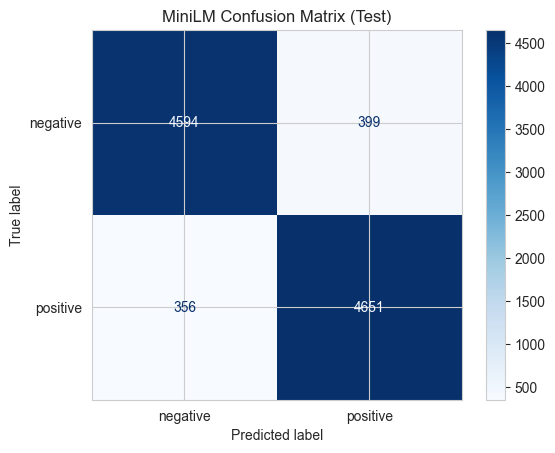

In [46]:
pred_test_minilm = trainer_minilm.predict(tokenized_minilm["test"])
logits_test_minilm = pred_test_minilm.predictions
labels_test_minilm = pred_test_minilm.label_ids
pred_labels_minilm = logits_test_minilm.argmax(axis=-1)

acc_test_minilm = metric_acc.compute(predictions=pred_labels_minilm, references=labels_test_minilm)
f1_test_minilm = metric_f1.compute(predictions=pred_labels_minilm, references=labels_test_minilm, average="macro")

print("MiniLM Test Accuracy:", acc_test_minilm)
print("MiniLM Test Macro-F1:", f1_test_minilm)

cm_minilm = confusion_matrix(labels_test_minilm, pred_labels_minilm)

print("\n=== Confusion Matrix (Text) ===")
print(f"{'':20} {'Predicted Negative':>20} {'Predicted Positive':>20}")
print(f"{'Actual Negative':20} {cm_minilm[0, 0]:>20} {cm_minilm[0, 1]:>20}")
print(f"{'Actual Positive':20} {cm_minilm[1, 0]:>20} {cm_minilm[1, 1]:>20}")

disp_minilm = ConfusionMatrixDisplay(confusion_matrix=cm_minilm, display_labels=["negative", "positive"])
disp_minilm.plot(cmap="Blues")
plt.title("MiniLM Confusion Matrix (Test)")
plt.show()


In [47]:
model_name_bpe = "distilroberta-base"

tokenizer_bpe = AutoTokenizer.from_pretrained(model_name_bpe)


def tokenize_bpe(batch):
    return tokenizer_bpe(
        batch["text"],
        truncation=True,
        padding="max_length",   # or "longest" if you prefer dynamic padding
        max_length=MAX_LENGTH,
    )

tokenized_bpe = hf_dataset.map(tokenize_bpe, batched=True)

tokenized_bpe


Map:   0%|          | 0/36000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 36000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 10000
    })
})

In [48]:
# Remove the original text column(s) so Trainer only sees tensors + labels
tokenized_bpe = tokenized_bpe.remove_columns(["text"])

# Make sure labels are called "labels" for Trainer
tokenized_bpe = tokenized_bpe.rename_column("label", "labels")

# Set to torch format
tokenized_bpe.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


In [49]:
train_small_bpe = tokenized_bpe["train"].shuffle(seed=42).select(range(8000))
val_small_bpe   = tokenized_bpe["validation"].shuffle(seed=42).select(range(2000))


In [50]:
num_labels = 2  # binary sentiment
id2label = {0: "negative", 1: "positive"}
label2id = {"negative": 0, "positive": 1}

model_bpe = AutoModelForSequenceClassification.from_pretrained(
    model_name_bpe,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

training_args_bpe = TrainingArguments(
    output_dir="./distilroberta_sentiment",
    eval_strategy="epoch",  
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=100,
    seed=42,
)

trainer_bpe = Trainer(
    model=model_bpe,
    args=training_args_bpe,
    train_dataset=train_small_bpe,
    eval_dataset=val_small_bpe,
    tokenizer=tokenizer_bpe,
    compute_metrics=compute_metrics,
)



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\vogle\AppData\Local\Temp\ipykernel_7324\1590910999.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_bpe = Trainer(


In [51]:
train_result_bpe = trainer_bpe.train()
eval_bpe_val = trainer_bpe.evaluate()

print("DistilRoBERTa (validation) metrics:")
print(eval_bpe_val)

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.302300,0.329926,0.885500,0.885386
2,0.173300,0.318925,0.899500,0.899418
3,0.177600,0.428274,0.904000,0.903962


DistilRoBERTa (validation) metrics:
{'eval_loss': 0.4282737374305725, 'eval_accuracy': 0.904, 'eval_f1': 0.9039615846338536, 'eval_runtime': 5.1031, 'eval_samples_per_second': 391.917, 'eval_steps_per_second': 12.345, 'epoch': 3.0}


DistilRoBERTa Test Accuracy: {'accuracy': 0.914}
DistilRoBERTa Test Macro-F1: {'f1': 0.9139990058285075}

=== Confusion Matrix (Text) ===
                       Predicted Negative   Predicted Positive
Actual Negative                      4553                  440
Actual Positive                       420                 4587


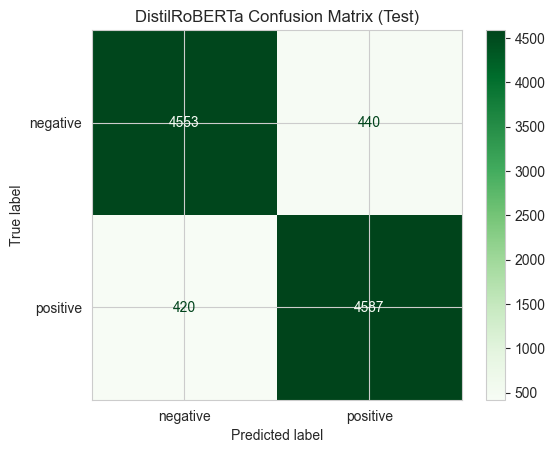

In [52]:
pred_test_bpe = trainer_bpe.predict(tokenized_bpe["test"])
logits_test_bpe = pred_test_bpe.predictions
labels_test_bpe = pred_test_bpe.label_ids
pred_labels_bpe = logits_test_bpe.argmax(axis=-1)

acc_test_bpe = metric_acc.compute(predictions=pred_labels_bpe, references=labels_test_bpe)
f1_test_bpe = metric_f1.compute(predictions=pred_labels_bpe, references=labels_test_bpe, average="macro")

print("DistilRoBERTa Test Accuracy:", acc_test_bpe)
print("DistilRoBERTa Test Macro-F1:", f1_test_bpe)
cm_bpe = confusion_matrix(labels_test_bpe, pred_labels_bpe)

print("\n=== Confusion Matrix (Text) ===")
print(f"{'':20} {'Predicted Negative':>20} {'Predicted Positive':>20}")
print(f"{'Actual Negative':20} {cm_bpe[0, 0]:>20} {cm_bpe[0, 1]:>20}")
print(f"{'Actual Positive':20} {cm_bpe[1, 0]:>20} {cm_bpe[1, 1]:>20}")

disp_bpe = ConfusionMatrixDisplay(confusion_matrix=cm_bpe, display_labels=["negative", "positive"])
disp_bpe.plot(cmap="Greens")
plt.title("DistilRoBERTa Confusion Matrix (Test)")
plt.show()


In [53]:
import torch
import torch.nn.functional as F

# Label id ↔ name mapping
id2label = {0: "negative", 1: "positive"}

def show_minilm_predictions(
    num_examples: int = 5,
    split: str = "test",
    max_review_chars: int = 300,
):
    """
    Print a few test reviews with:
    - gold label
    - predicted label
    - prediction probability
    """
    # HuggingFace test datasets
    ds_text = hf_dataset[split]          # original text + labels
    ds_tok  = tokenized_minilm[split]    # tokenized for MiniLM

    # Take first `num_examples` 
    indices = list(range(min(num_examples, len(ds_tok))))
    small_tok_ds = ds_tok.select(indices)

    # Use Trainer to predict on this small subset
    preds = trainer_minilm.predict(small_tok_ds)
    logits = preds.predictions           # shape (N, 2) for binary classification
    probs = F.softmax(torch.tensor(logits), dim=-1).numpy()

    for i, idx in enumerate(indices):
        ex = ds_text[idx]
        text = ex["text"]
        gold = id2label[ex["label"]]
        pred_id = int(probs[i].argmax())
        pred_label = id2label[pred_id]
        pred_prob = float(probs[i][pred_id])

        print("=" * 100)
        print(f"Example {i+1} (index={idx})")
        print(f"Gold label      : {gold}")
        print(f"Predicted label : {pred_label}  (p = {pred_prob:.3f})")
        print("-" * 100)
        # Show truncated text for readability
        if len(text) > max_review_chars:
            print(text[:max_review_chars] + "...")
        else:
            print(text)
        print()  # blank line

show_minilm_predictions(num_examples=5)

Example 1 (index=0)
Gold label      : negative
Predicted label : negative  (p = 0.997)
----------------------------------------------------------------------------------------------------
first off i want to say that i lean liberal on the political scale and i found the movie offensive . i managed to watch the whole doggone disgrace of a film . this movie brings a low to original ideas . yes it was original thus my 2 stars instead of 1. are our film writers that uncreative that they ...

Example 2 (index=1)
Gold label      : negative
Predicted label : negative  (p = 0.996)
----------------------------------------------------------------------------------------------------
i was excited to see a sitcom that would hopefully represent indian candians but i found this show to be not funny at all . the producers and cast are probably happy to get both bad and good feed back because as far as they are concerned it 's getting talked about ! i was ready for some stereotyping...

Example 3 (ind

## Task 4: Model Evaluation & Benchmarking

In [54]:
import random

N_SAMPLE = 100
SEED = 42

random.seed(SEED)
indices_100 = random.sample(range(len(hf_dataset["test"])), k=N_SAMPLE)

sample_text_ds = hf_dataset["test"].select(indices_100)          # original text + gold labels
sample_tok_ds   = tokenized_minilm["test"].select(indices_100)   # tokenized for MiniLM

len(sample_text_ds), len(sample_tok_ds)


(100, 100)

In [55]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

# Run MiniLM on the 100-tokenized samples
preds_100 = trainer_minilm.predict(sample_tok_ds)
logits_100 = preds_100.predictions
labels_100 = preds_100.label_ids
probs_100 = F.softmax(torch.tensor(logits_100), dim=-1).numpy()
pred_labels_100 = probs_100.argmax(axis=-1)

acc_100 = accuracy_score(labels_100, pred_labels_100)
f1_100 = f1_score(labels_100, pred_labels_100, average="macro")

print(f"MiniLM on 100-sample subset:")
print(f"  Accuracy:   {acc_100:.3f}")
print(f"  Macro-F1:   {f1_100:.3f}")


MiniLM on 100-sample subset:
  Accuracy:   0.950
  Macro-F1:   0.950


In [56]:
def simple_classical_tokens(text: str):
    """
    Cleans text using the N-gram preprocessor settings and returns tokens.
    """
    # ngram_prep.process_text returns a single string of space-separated tokens
    cleaned_text = ngram_prep.process_text(text)
    # Split back into a list of tokens
    return cleaned_text.split()
    
# Helper function to add padding consistent with training
def build_ngram_sentences(token_lists, n=2):
    padded_sentences = []
    for tokens in token_lists:
        if n == 2:
            # Bigram model was trained on ['<s>', w1, ..., '</s>'] (See Cell 39 adaptation)
            padded = ['<s>'] + tokens + ['</s>']
        elif n == 3:
            # Trigram model was trained on ['<s>', '<s>', w1, ..., '</s>']
            padded = ['<s>', '<s>'] + tokens + ['</s>']
        else:
            padded = tokens
        padded_sentences.append(padded)
    return padded_sentences

# Generate tokens
sample_tokens_100 = [
    simple_classical_tokens(x["text"])
    for x in sample_text_ds
]

# Build padded sentences
sample_sents_bigram_100  = build_ngram_sentences(sample_tokens_100, n=2)
sample_sents_trigram_100 = build_ngram_sentences(sample_tokens_100, n=3)


# Use the model variable names from Cell 39 (bigram_model, trigram_model)
pp_bigram_100  = bigram_model.calculate_perplexity(sample_sents_bigram_100)
pp_trigram_100 = trigram_model.calculate_perplexity(sample_sents_trigram_100)

print(f"Bigram Perplexity (Subset): {pp_bigram_100:.2f}")
print(f"Trigram Perplexity (Subset): {pp_trigram_100:.2f}")



Bigram Perplexity (Subset): 395.37
Trigram Perplexity (Subset): 502.73


In [57]:
# LSTM LM Perplexity on the same 100 texts ---


def tokens_to_ids(token_lists, vocab):
    return [[vocab.stoi(t) for t in tokens] for tokens in token_lists]


sample_tokens_neural_100 = [
    neural_prep.process_text(x["text"]).split()
    for x in sample_text_ds
]

# Add Neural padding: ['<s>'] + tokens + ['</s>'] 
MAX_LEN_NEURAL = 100 
sample_tokens_neural_padded = []
for tokens in sample_tokens_neural_100:
    padded = ['<s>'] + tokens[:MAX_LEN_NEURAL] + ['</s>']
    sample_tokens_neural_padded.append(padded)

# Convert to IDs
sample_ids_100 = tokens_to_ids(sample_tokens_neural_padded, vocab)

# Create Dataset and Loader
sample_dataset_lstm_100 = IMDBDataset(sample_tokens_neural_padded, vocab) 
sample_loader_lstm_100 = DataLoader(
    sample_dataset_lstm_100,
    batch_size=32, # Use a standard batch size
    shuffle=False,
    collate_fn=collate_fn
)

# Evaluate
model_lstm.eval()
total_loss = 0
total_batches = 0
criterion = nn.CrossEntropyLoss(ignore_index=0)

with torch.no_grad():
    for inputs, targets, lengths in sample_loader_lstm_100:
        inputs, targets = inputs.to(device), targets.to(device)
        logits, _ = model_lstm(inputs, lengths)
        loss = criterion(logits.view(-1, len(vocab)), targets.view(-1))
        total_loss += loss.item()
        total_batches += 1

avg_loss = total_loss / total_batches if total_batches > 0 else 999
pp_lstm_100 = math.exp(avg_loss)

print(f"LSTM Perplexity (Subset): {pp_lstm_100:.2f}")

LSTM Perplexity (Subset): 178.53


In [58]:

print("\n=== Perplexity Comparison (100-sample subset) ===")
print(f"Bigram LM    : {pp_bigram_100:.1f}")
print(f"Trigram LM   : {pp_trigram_100:.1f}")
print(f"LSTM neural LM: {pp_lstm_100:.1f}")



=== Perplexity Comparison (100-sample subset) ===
Bigram LM    : 395.4
Trigram LM   : 502.7
LSTM neural LM: 178.5


In [59]:
# Build a DataFrame with text, gold label, model prediction & prob
id2label = {0: "negative", 1: "positive"}

rows = []
for i, ex in enumerate(sample_text_ds):
    text = ex["text"]
    gold = id2label[ex["label"]]
    pred_id = int(pred_labels_100[i])
    pred_label = id2label[pred_id]
    pred_prob = float(probs_100[i, pred_id])

    rows.append({
        "sample_index": indices_100[i],
        "text": text,
        "gold_label": gold,
        "model_label": pred_label,
        "model_confidence": pred_prob,
        # columns for human annotators to fill in:
        "human_label_annotator1": "",
        "human_label_annotator2": "",
        "human_confidence_annotator1": "",
        "human_confidence_annotator2": "",
    })

df_100 = pd.DataFrame(rows)
df_100.to_csv("human_eval_100.csv", index=False)

df_100.head()


,sample_index,text,gold_label,model_label,model_confidence,human_label_annotator1,human_label_annotator2,human_confidence_annotator1,human_confidence_annotator2
0,1824,"i just watched this short at the planetout movies . starcrossed was a very sweet , sad , little movie about two brothers that are in love . there is some great , subtle acting from both the male leads . often times movies with this subject matter seem to get too caught up in the controversy and shock value of the plot that they forget that there is an actual story . luckily writer director james burkhammer does not do this , and instead lets the story play out with honesty . the sequences of the two boys first falling in love are very sweet .",positive,positive,0.993686,,,,
1,409,"i seem to remember a lot of hype about this movie when it came out , but had avoided seeing it throughout the years . i wish i 'd waited longer . maybe this movie was funny in 1988 , i do n't know . i was younger then , but it did n't seem like the world was that different . michelle pfeiffer , lovely as she is , is never convincing . mercedes ruehl not only chews scenery , but stuffs it in her cheeks like a gerbil to save for later . dean stockwell is about as convincing as a mob boss as james gandolfini would be as principal dancer for the bolshoi . and matthew modine demonstrated the most pronounced case of delayed puberty i 've ever seen . all in all , it 's not bad enough to make you want to pluck out your eyes with a melon-baller , but it 's not far off .",negative,negative,0.989687,,,,
2,4506,"i found this film rather brilliant . initially i wanted a `` when animals attack '' flick along the lines of `` frankenfish '' or even `` rogue '' but was delivered a truly horrific ordeal that was not devoid of humanity . having been to the areas this was made ( including the croc farm at the start of the movie , even sharing the same guide ! ) it added to the fear factor . those crocs really are everywhere up there , though i do n't think they had the `` attitude '' of this beastie . yes there were some melodramatic moments but they contributed rather distract from the whole atmosphere . i genuinely cared for the characters and shuddered contemplating `` what would i do ? '' in their boat . not knowing where your enemy lurked or the sound of the croc chowing down at night was genuinely frightening . i would argue that this flick is one of the best horrors i have seen in years ( coming close to the descent ) . i give it four alligator handbags .",positive,positive,0.995506,,,,
3,4012,"sure , it 's hard being gay , especially in the south . we get it . over ... and over again . what stood out was that the film makers focused almost wholly on the more `` extreme '' characters in these small town gay bars ; the drag queens , the seedy sleaze of a bar long-closed , and on a guy who was brutally murdered for being gay , yet had nothing to do with either of the bars which were the focus of this film . there were snippets of interviews from other people , people viewers would , perhaps , be better able to relate to . but they were glossed over , practically skipped , maybe shown in a glimpse in the background . it would have been more interesting , to me at least , to hear the experiences of the more common gay men and women who were either enriched or otherwise by the experiences of a small town gay bar and/or the absence of that community .",negative,negative,0.990703,,,,
4,3657,"despite all of the comparisons to house of frankenstein , this movie outshines its predecessor and is one of the funnest monster movies in the universal monsters series , and sadly , the last . o.k . so it does n't exactly stack up to something like the bride of frankenstein as one a classic to revered by fans of all movies , but with a cast of dracula , the wolf man and frankenstein 's monster ( what ? no mummy ? ) you ca n't help but enjoy this schlock fest ! and unlike house of frankenstein , the monsters in this 

In [60]:
df_annotated = pd.read_csv("human_eval_100.annotated.csv")

# Convert human labels to ids (e.g. using annotator 1)
label2id = {"negative": 0, "positive": 1}

human_labels_1 = df_annotated["human_label_annotator1"].map(label2id)
gold_labels = df_annotated["gold_label"].map(label2id)
model_labels = df_annotated["model_label"].map(label2id)

# Human vs gold
acc_human_vs_gold = accuracy_score(gold_labels, human_labels_1)
f1_human_vs_gold = f1_score(gold_labels, human_labels_1, average="macro")

# Model vs gold (should match acc_100/f1_100)
acc_model_vs_gold = accuracy_score(gold_labels, model_labels)
f1_model_vs_gold = f1_score(gold_labels, model_labels, average="macro")

# Agreement between human and model
acc_model_vs_human = accuracy_score(human_labels_1, model_labels)
f1_model_vs_human = f1_score(human_labels_1, model_labels, average="macro")

print("Human vs gold:   acc={:.3f}, macro-F1={:.3f}".format(acc_human_vs_gold, f1_human_vs_gold))
print("Model vs gold:   acc={:.3f}, macro-F1={:.3f}".format(acc_model_vs_gold, f1_model_vs_gold))
print("Model vs human:  acc={:.3f}, macro-F1={:.3f}".format(acc_model_vs_human, f1_model_vs_human))


Human vs gold:   acc=0.940, macro-F1=0.939
Model vs gold:   acc=0.860, macro-F1=0.858
Model vs human:  acc=0.860, macro-F1=0.858


In [61]:
disagree_idx = df_annotated[gold_labels != human_labels_1].index
df_annotated.loc[disagree_idx, ["text", "gold_label", "human_label_annotator1", "model_label"]].head()


,text,gold_label,human_label_annotator1,model_label
10,"I raced to the library to check out this miniseries after having just finished listening to the marvelous ""talking books"" unabridged version of the book. The first half of this TV version is really very good, but it stumbles quite a bit in the second half. The relationship with the trustee is overplayed and conflicts are inserted between Jean and Joe that don't exist in Shute's story, unwisely in my opinion, as they greatly diminish the power of their love story. I was disappointed to find that the wonderful Bryan Brown's Joe seemed a lot cockier and much less appealing than the man in the book, but Helen Morse's Jean was really quite good. I think they would have had to make this a 10-hour miniseries to develop the outback story properly. But all that said, I did watch whole thing in more or less one go and did appreciate its merits, all the while wishing that someone would do a less soapy remake.",positive,negative,positive
17,"Average adventure movie that took a serious story and ""Holywoodised"" it.The watering down effect done particularly towards the average script snatched away this movie's place as a would be solid classic. Why water down such a great storyline?Probably because it deals with ""sensitive"" colonial subject matters and the producers do not want to create political heat,just quick profits thank you.The directing,cinematography and soundtrack and acting was good.The screenplay was average.The charm of Connery made up for his wrong Arabic accent and all the scenes with President T. Roosevelt were masterpiece takes.The costumes/sets here was very good.Too bad we did not get more of a serious historical drama since this is what the story demands.Only for big fans of the lead actors or fans of exotic Romance/Adventure Holywood movies.....",positive,negative,positive
30,"That is the answer. The question is: What is the single reason to watch this movie? I loved her in ""My Name Is Julia Ross."" That is one of the best films noir of all time. Noir or whatever one may call it, it's a very unsettling movie. She is fun in one of the worst major studio releases of all time, too. That would be ""The Guilt Of Janet Ames."" This one has a spooky, promising title. It has a good cast. It has a fine director. I was expecting something dark. Maybe something a little tawdry. Instead, it's an uninspired, routine espionage movie. It's pretty much is a total bore. At least it was to me. Ms. Foch is captivating. And that is about it.",negative,positive,positive
31,"If anything, William Girdler was an opportunist who wanted a piece of the action in regards to whatever was popular during the time. I mean, a blaxploitation flick in Louisville, Kentucky..who would of thunk it?!?! I can just imagine the enthusiasm he must've had getting Pam Grier, quite a hot item, to star in his picture. If you are pretty familiar with the genre, Girdler's Sheba, Baby doesn't necessarily stray too far from formula. Despite a change of venue, the film still deals with a ruthless businessman nicknamed Shark who muscles in on loan companies, using stooges to threaten them in order to get their signatures. Grier is Sheba Shayne, a former Louisville cop working in Chicago who returns home at the request of her father's partner, Brick(Austin Stoker, Assault on Precinct 13). Sheba's father, despite Shark's bullying tactics(..his man in town is Pilot, a wannabe gangster, equipped with stooges who aren't that menacing, rather buffoonish in nature, so thin-skinned they hire hit men outside of town to shoot up the Shayne Loan building), won't give up his company, and this eventually costs him his life when a warning through the use of brute force, leads to his being killed. Sheba will get her revenge on all those responsible for his father's death. In other words, Shark's ass is grass..can you dig it? Seeing Grier with a magnum is enough to sell this particular film, the novelty of the setting being in

In [62]:
judge_rows = []
for i, row in df_100.iterrows():
    text = row["text"]
    model_label = row["model_label"]

    prompt = f"""
You are a strict sentiment annotator.

Read the following movie review and then answer with a single word:
either "positive" or "negative".

Review:
{text}

What is the correct overall sentiment of this review? Answer with only one word: positive or negative.
    """.strip()

    judge_rows.append({
        "sample_index": row["sample_index"],
        "text": text,
        "gold_label": row["gold_label"],
        "model_label": model_label,
        "judge_prompt": prompt,
        "judge_label": ""  # to fill with LLM output
    })

df_judge = pd.DataFrame(judge_rows)
df_judge.to_csv("llm_judge_100_template.csv", index=False)
df_judge.head()


,sample_index,text,gold_label,model_label,judge_prompt,judge_label
0,1824,"i just watched this short at the planetout movies . starcrossed was a very sweet , sad , little movie about two brothers that are in love . there is some great , subtle acting from both the male leads . often times movies with this subject matter seem to get too caught up in the controversy and shock value of the plot that they forget that there is an actual story . luckily writer director james burkhammer does not do this , and instead lets the story play out with honesty . the sequences of the two boys first falling in love are very sweet .",positive,positive,"You are a strict sentiment annotator.\n\nRead the following movie review and then answer with a single word:\neither ""positive"" or ""negative"".\n\nReview:\ni just watched this short at the planetout movies . starcrossed was a very sweet , sad , little movie about two brothers that are in love . there is some great , subtle acting from both the male leads . often times movies with this subject matter seem to get too caught up in the controversy and shock value of the plot that they forget that there is an actual story . luckily writer director james burkhammer does not do this , and instead lets the story play out with honesty . the sequences of the two boys first falling in love are very sweet .\n\nWhat is the correct overall sentiment of this review? Answer with only one word: positive or negative.",
1,409,"i seem to remember a lot of hype about this movie when it came out , but had avoided seeing it throughout the years . i wish i 'd waited longer . maybe this movie was funny in 1988 , i do n't know . i was younger then , but it did n't seem like the world was that different . michelle pfeiffer , lovely as she is , is never convincing . mercedes ruehl not only chews scenery , but stuffs it in her cheeks like a gerbil to save for later . dean stockwell is about as convincing as a mob boss as james gandolfini would be as principal dancer for the bolshoi . and matthew modine demonstrated the most pronounced case of delayed puberty i 've ever seen . all in all , it 's not bad enough to make you want to pluck out your eyes with a melon-baller , but it 's not far off .",negative,negative,"You are a strict sentiment annotator.\n\nRead the following movie review and then answer with a single word:\neither ""positive"" or ""negative"".\n\nReview:\ni seem to remember a lot of hype about this movie when it came out , but had avoided seeing it throughout the years . i wish i 'd waited longer . maybe this movie was funny in 1988 , i do n't know . i was younger then , but it did n't seem like the world was that different . michelle pfeiffer , lovely as she is , is never convincing . mercedes ruehl not only chews scenery , but stuffs it in her cheeks like a gerbil to save for later . dean stockwell is about as convincing as a mob boss as james gandolfini would be as principal dancer for the bolshoi . and matthew modine demonstrated the most pronounced case of delayed puberty i 've ever seen . all in all , it 's not bad enough to make you want to pluck out your eyes with a melon-baller , but it 's not far off .\n\nWhat is the correct overall sentiment of this review? Answer with only one word: positive or negative.",
2,4506,"i found this film rather brilliant . initially i wanted a `` when animals attack '' flick along the lines of `` frankenfish '' or even `` rogue '' but was delivered a truly horrific ordeal that was not devoid of humanity . having been to the areas this was made ( including the croc farm at the start of the movie , even sharing the same guide ! ) it added to the fear factor . those crocs really are everywhere up there , though i do n't think they had the `` attitude '' of this beastie . yes there were some melodramatic moments but they contributed rather distract from the whole atmosphere . i genuinely cared for the characters and shuddered contemplating `` what would i do ? '' in their

In [67]:
import pandas as pd
import ollama  # pip install ollama

# Name of your locally available Ollama model
# e.g. "llama3.2:latest", "llama3.2:1b-instruct", "mistral:latest", etc.
JUDGE_MODEL_NAME = "llama3.2:latest"

df_judge = pd.read_csv("llm_judge_100_template.csv")

def ask_ollama(prompt: str, model: str, max_tokens: int = 10) -> str:
    """
    Call Ollama's /chat endpoint via the Python client.
    Returns the model's text response.
    """
    response = ollama.chat(
        model=model,
        messages=[
            {"role": "user", "content": prompt}
        ],
        options={
            "num_predict": max_tokens,
            "temperature": 0.0,  # deterministic, similar to do_sample=False
        },
    )
    # For chat, the text is in response["message"]["content"]
    return response["message"]["content"]

def extract_label_from_response(text: str) -> str:
    text_low = text.lower()
    if "positive" in text_low and "negative" not in text_low:
        return "positive"
    if "negative" in text_low and "positive" not in text_low:
        return "negative"
    # fallback (you can improve this)
    return "positive" if "positive" in text_low else "negative"

judge_labels = []
for prompt in df_judge["judge_prompt"]:
    out = ask_ollama(prompt, JUDGE_MODEL_NAME, max_tokens=10)
    label = extract_label_from_response(out)
    judge_labels.append(label)

df_judge["judge_label"] = judge_labels
df_judge.to_csv("llm_judge_100_annotated.csv", index=False)

print("Saved to llm_judge_100_annotated.csv")


Saved to llm_judge_100_annotated.csv


In [68]:
df_judge_annotated = pd.read_csv("llm_judge_100_annotated.csv")

judge_labels = df_judge_annotated["judge_label"].map(label2id)
gold_labels  = df_judge_annotated["gold_label"].map(label2id)
model_labels = df_judge_annotated["model_label"].map(label2id)

# Judge vs gold
acc_judge_vs_gold = accuracy_score(gold_labels, judge_labels)
f1_judge_vs_gold = f1_score(gold_labels, judge_labels, average="macro")

# Judge vs model
acc_judge_vs_model = accuracy_score(model_labels, judge_labels)
f1_judge_vs_model = f1_score(model_labels, judge_labels, average="macro")

print("LLM-judge vs gold:   acc={:.3f}, macro-F1={:.3f}".format(acc_judge_vs_gold, f1_judge_vs_gold))
print("LLM-judge vs model:  acc={:.3f}, macro-F1={:.3f}".format(acc_judge_vs_model, f1_judge_vs_model))


LLM-judge vs gold:   acc=0.920, macro-F1=0.920
LLM-judge vs model:  acc=0.910, macro-F1=0.910
